In [ ]:
from pathlib import Path
import requests

    1. Path and request module are used for fetching data from src.
    2. The data is a zip file which contains the MNIST dataset in
       pickle format.
    3. Pickle format is used for serializing data(binary stream)
       objects in python.

In [ ]:
DATA_PATH = Path("data")
PATH = DATA_PATH / "mnist"

PATH.mkdir( parents=True, exist_ok = True )

URL = "https://github.com/pytorch/tutorials/raw/master/_static/"
FILENAME = "mnist.pkl.gz"

if not (PATH / FILENAME).exists():

    content = requests.get(URL+FILENAME).content
    (PATH / FILENAME).open("wb").write(content)

Here we use gzip and pickle module to unzip and access the dataset.

In [ ]:
import pickle
import gzip

with gzip.open((PATH / FILENAME).as_posix(),"rb") as f:
        ((x_train,y_train) ,(x_valid,y_valid),_) = pickle.load(f,
            encoding= "latin-1")


    1. The dataset are pixels of images but they are stored as a
       flattened single vector or array with 784(28*28) columns or
       entries. 
    2. Inorder to plot the image we need to reshape it to 2D.
    3. There are 50,000 images or instances.

(50000, 784)


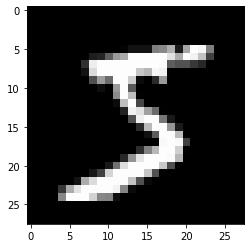

In [ ]:
from matplotlib import pyplot
import numpy as np

pyplot.imshow(x_train[0].reshape(28,28),cmap = "gray")
print(x_train.shape)

1. PyTorch works on torch.tensor data-objects but our data is an
   array. Hence we need to construct tensor object from our dataset.
2. Torch.tensor is a module which does this,  hence we use map and
   (tensor module & corresponding array objects) to replace the array
   storing variables with tensor objects. 

In [ ]:
import torch

x_train , Y_train , x_valid , y_valid = map(
        torch.tensor , (x_train,y_train,x_valid,y_valid)
)
n,c = x_train.shape

print(x_train,y_train)
print(x_train.shape)
print(y_train.min(),y_train.max())

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]]) [5 0 4 ... 8 4 8]
torch.Size([50000, 784])
0 9


### Model (with tensor operations)

In [ ]:
import math

weights = torch.randn(784,10) / math.sqrt(784)
weights.requires_grad_()
bias = torch.zeros(10,requires_grad= True)

In [ ]:
def log_softmax(x):
    return x - x.exp().sum().log().unsqueeze(-1)

def model(xb):
    return log_softmax(xb @ weights + bias)

In [ ]:
bs = 64

xb = x_train[0:bs]
preds = model(xb)
preds[0] , preds.shape
print(preds[0],preds.shape)

tensor([-6.3358, -6.3654, -6.0178, -6.9725, -6.6209, -6.9156, -6.5498, -6.7311,
        -6.8735, -6.0289], grad_fn=<SelectBackward>) torch.Size([64, 10])


In [ ]:
l = xb @ weights + bias

In [ ]:
l.shape

torch.Size([64, 10])

In [ ]:
log_soft = l - l.exp().sum(-1).log().unsqueeze(-1)

In [ ]:
log_soft

tensor([[-2.1530, -2.1826, -1.8350, -2.7896, -2.4381, -2.7327, -2.3669, -2.5482,
         -2.6906, -1.8460],
        [-2.2337, -2.1499, -1.6490, -2.6603, -2.8657, -2.8566, -2.3212, -2.2682,
         -3.1455, -1.8637],
        [-2.3556, -2.7154, -2.2518, -2.2810, -2.1251, -2.2335, -2.5112, -1.9273,
         -2.6104, -2.2556],
        [-2.6266, -1.9856, -2.0644, -2.0906, -2.3576, -2.4838, -2.4762, -2.5211,
         -2.4047, -2.2342],
        [-2.2163, -1.9715, -2.2950, -2.7442, -2.8149, -2.5337, -2.4659, -2.3107,
         -2.2164, -1.8690],
        [-2.5693, -2.2976, -2.2553, -2.3227, -2.5291, -2.6312, -2.2422, -2.0860,
         -2.3256, -1.9647],
        [-2.5028, -2.2221, -2.1175, -2.5447, -2.7324, -2.3117, -2.8167, -2.2276,
         -2.4744, -1.6349],
        [-2.5226, -2.0071, -2.0816, -2.7307, -2.5080, -2.6356, -2.1809, -2.3033,
         -2.4943, -1.9177],
        [-2.4303, -2.1340, -2.1799, -2.4443, -2.7089, -2.1988, -2.4068, -2.4937,
         -2.4744, -1.8369],
        [-2.4532, -

In [ ]:
softmax = l.exp() / l.exp().sum()

In [ ]:
softmax

tensor([[0.0018, 0.0017, 0.0024, 0.0009, 0.0013, 0.0010, 0.0014, 0.0012, 0.0010,
         0.0024],
        [0.0018, 0.0019, 0.0032, 0.0012, 0.0010, 0.0010, 0.0016, 0.0017, 0.0007,
         0.0026],
        [0.0013, 0.0009, 0.0014, 0.0014, 0.0016, 0.0015, 0.0011, 0.0020, 0.0010,
         0.0014],
        [0.0011, 0.0020, 0.0019, 0.0018, 0.0014, 0.0012, 0.0012, 0.0012, 0.0013,
         0.0016],
        [0.0019, 0.0024, 0.0017, 0.0011, 0.0010, 0.0014, 0.0014, 0.0017, 0.0019,
         0.0026],
        [0.0010, 0.0013, 0.0013, 0.0013, 0.0010, 0.0009, 0.0014, 0.0016, 0.0013,
         0.0018],
        [0.0013, 0.0017, 0.0019, 0.0012, 0.0010, 0.0015, 0.0009, 0.0017, 0.0013,
         0.0030],
        [0.0011, 0.0019, 0.0017, 0.0009, 0.0011, 0.0010, 0.0016, 0.0014, 0.0011,
         0.0020],
        [0.0013, 0.0018, 0.0017, 0.0013, 0.0010, 0.0017, 0.0014, 0.0013, 0.0013,
         0.0024],
        [0.0013, 0.0015, 0.0017, 0.0012, 0.0014, 0.0017, 0.0012, 0.0022, 0.0011,
         0.0019],
        [0

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=1b0fc471-afe9-40dd-afe8-89e46e68c6e6' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>